# NanoSIMS Preprocessing

In [2]:
import os
import copy
import tifffile
import numpy as np
from matplotlib import pyplot as plt

import sims # For reading Cameca NanoSIMS data files (.im)
from pystackreg import StackReg # Image registration based on Thevenaz et al.
from pystackreg.util import to_uint16

Matplotlib created a temporary cache directory at /tmp/matplotlib-z7g9pun6 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Read raw data
Author: Johann Maximilian Zollner, maximilian.zollner@tum.de

We use the [SIMS](https://pypi.org/project/sims/) python module to read Cameca nanoSIMS data files.

In [6]:
# Choose a ".im" file from the "Black_sand_soils" dataset to process
# Remember to add the root directory "/tf" to the path
path = "/path/to/data.im"

In [7]:
raw = sims.SIMS(path)
data = raw.data.data
species = raw.data.species.data
channels, slices, rows, cols = raw.data.data.shape

print("Shape: ", raw.data.data.shape)
print("Species: ", species)
print("Example values: ", data[0,0,0,1], data[0,0,-1,1])

Shape:  (7, 40, 256, 256)
Species:  ['12C' '13C' '16O' '12C 14N' '12C 15N' '27Al 16O' '56Fe 16O']
Example values:  56 72


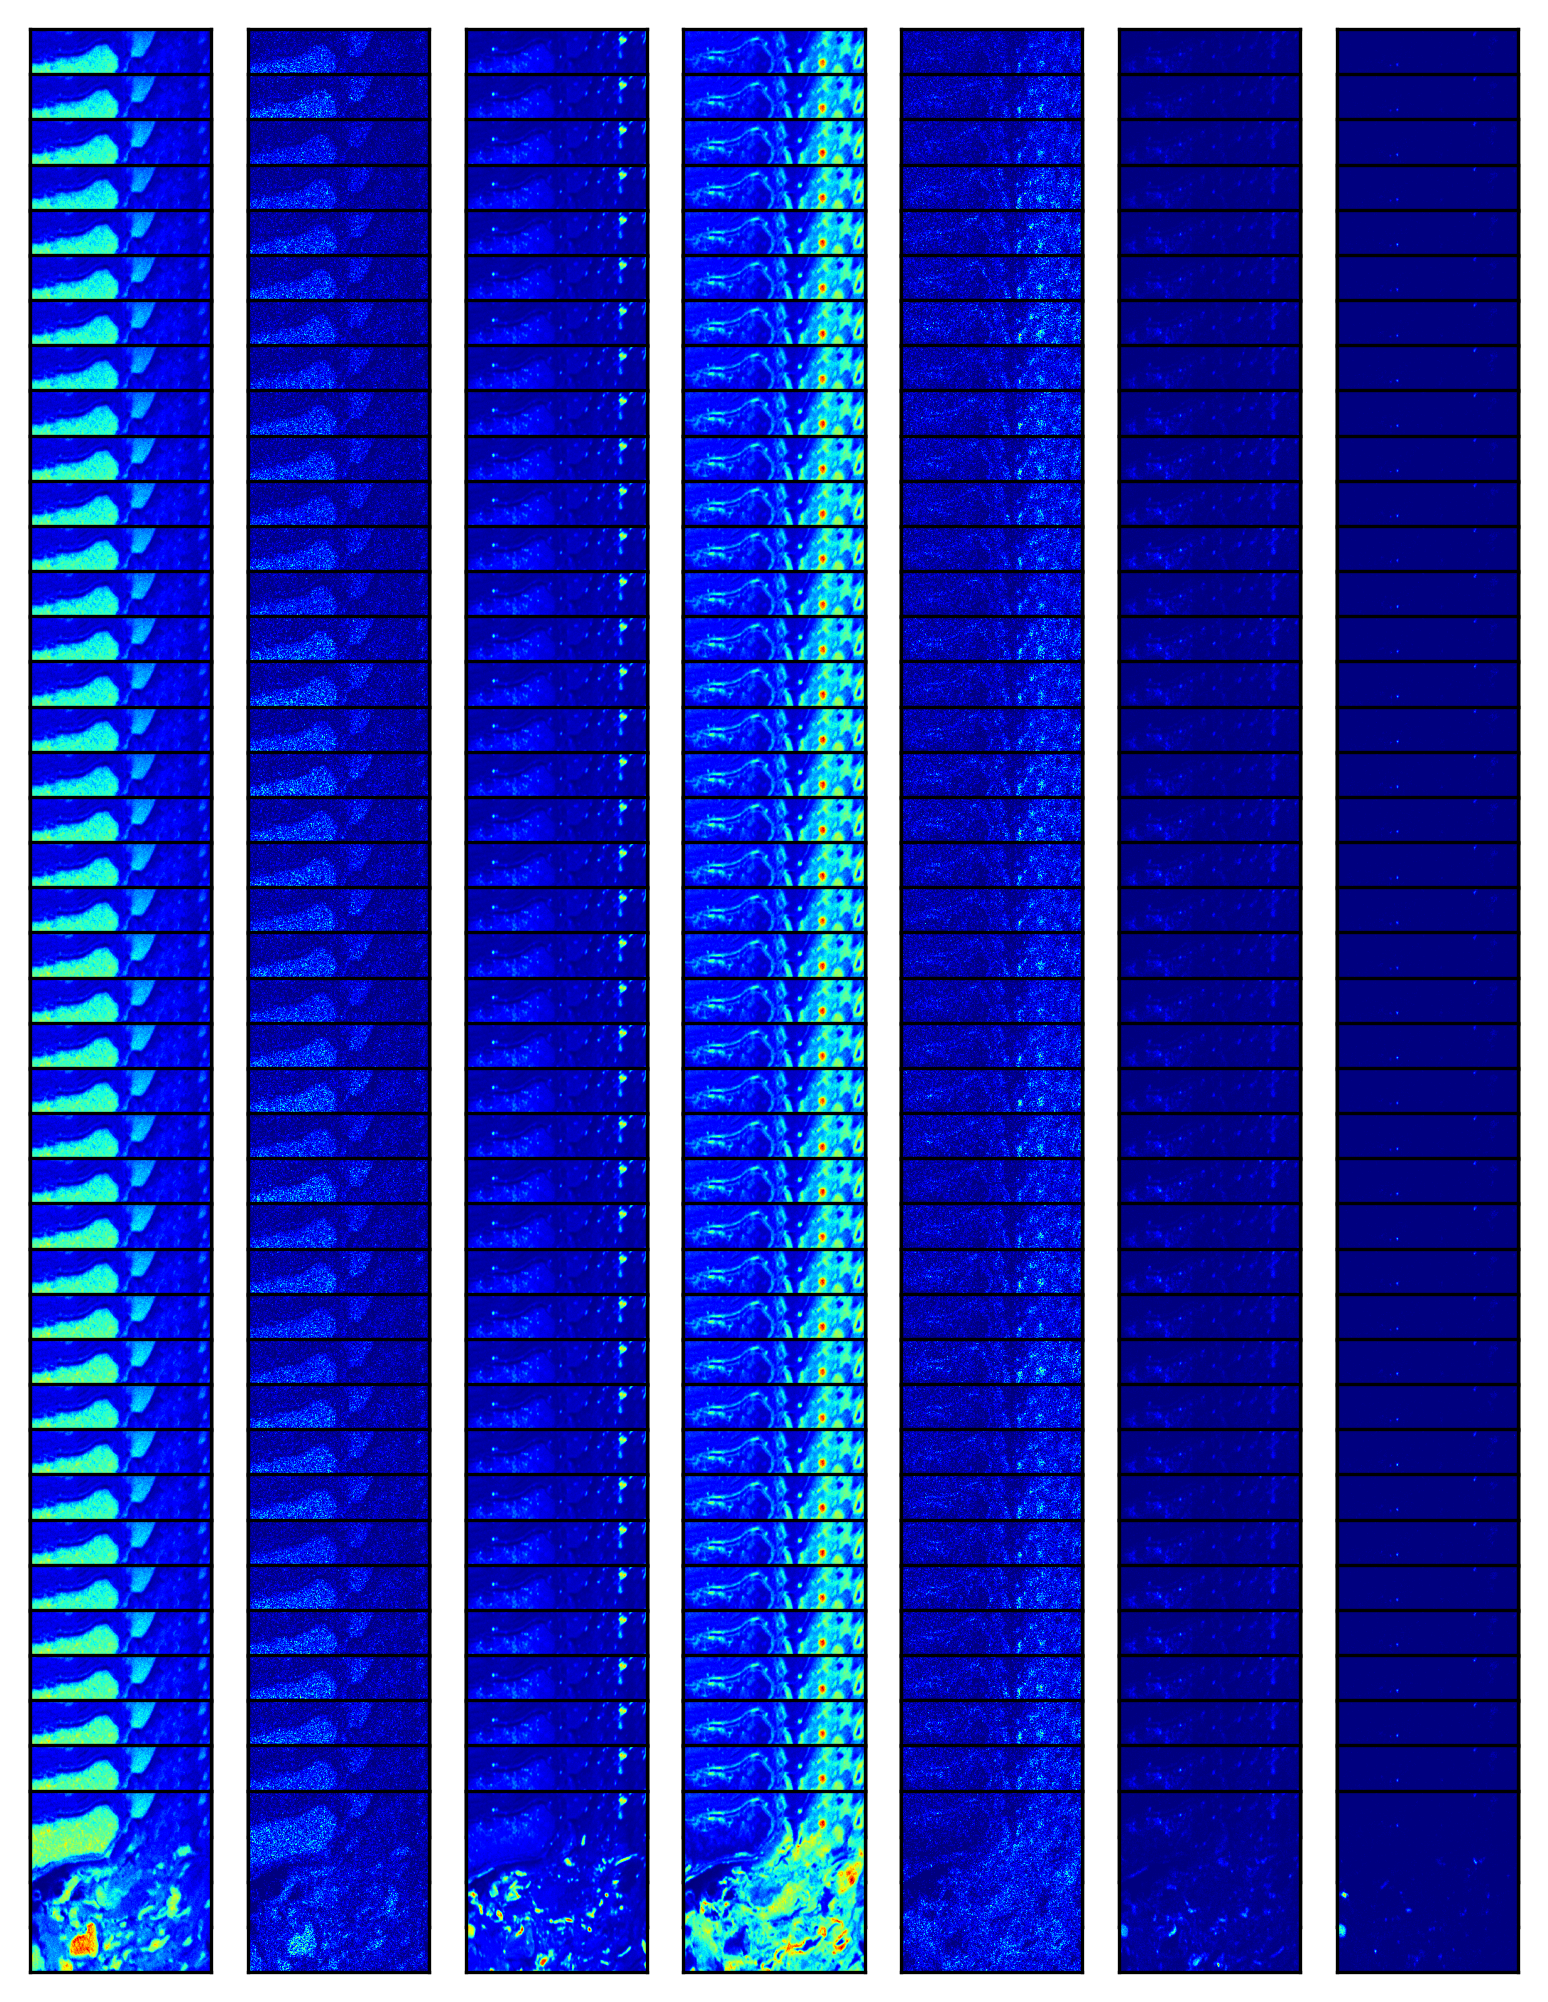

In [8]:
fig = plt.figure(dpi=300)
plt.set_cmap('jet')
# You may adjust the spaces here
plt.subplots_adjust(bottom=-0.5, hspace=-0.8)
k=1
for slice in range(slices):
    for channel in range(channels):
        plt.subplot(slices,channels,k)
        k+=1
        plt.imshow(data[channel,slice,:,:])
        plt.tick_params(left = False,right=False,labelleft=False,labelbottom=False,bottom=False)

# Preprocessing

## 1 Dead Time Correction
The dead time is the time after each event when the system cannot record another event. Here, the default value for the Cameca NanoSIMS system is set to 0.000044 seconds.

In [9]:
def dtc(data):
    return data/(1-data*0.000044)

In [10]:
data_dtc = dtc(data)

In [12]:
print("Shape: ", data_dtc.shape)
print("Example values: ", data_dtc[0,0,0,1], data_dtc[0,0,-1,1])

Shape:  (7, 40, 256, 256)
Example values:  56.138324832387006 72.22882090462585


## 2 Correct column and row
Correct column and row of each scan due to a drift, which concerns temperature differences during measurement. 
The lowermost row should go to the top, and the rightmost column should go to the left while we first correct the column and then the row.

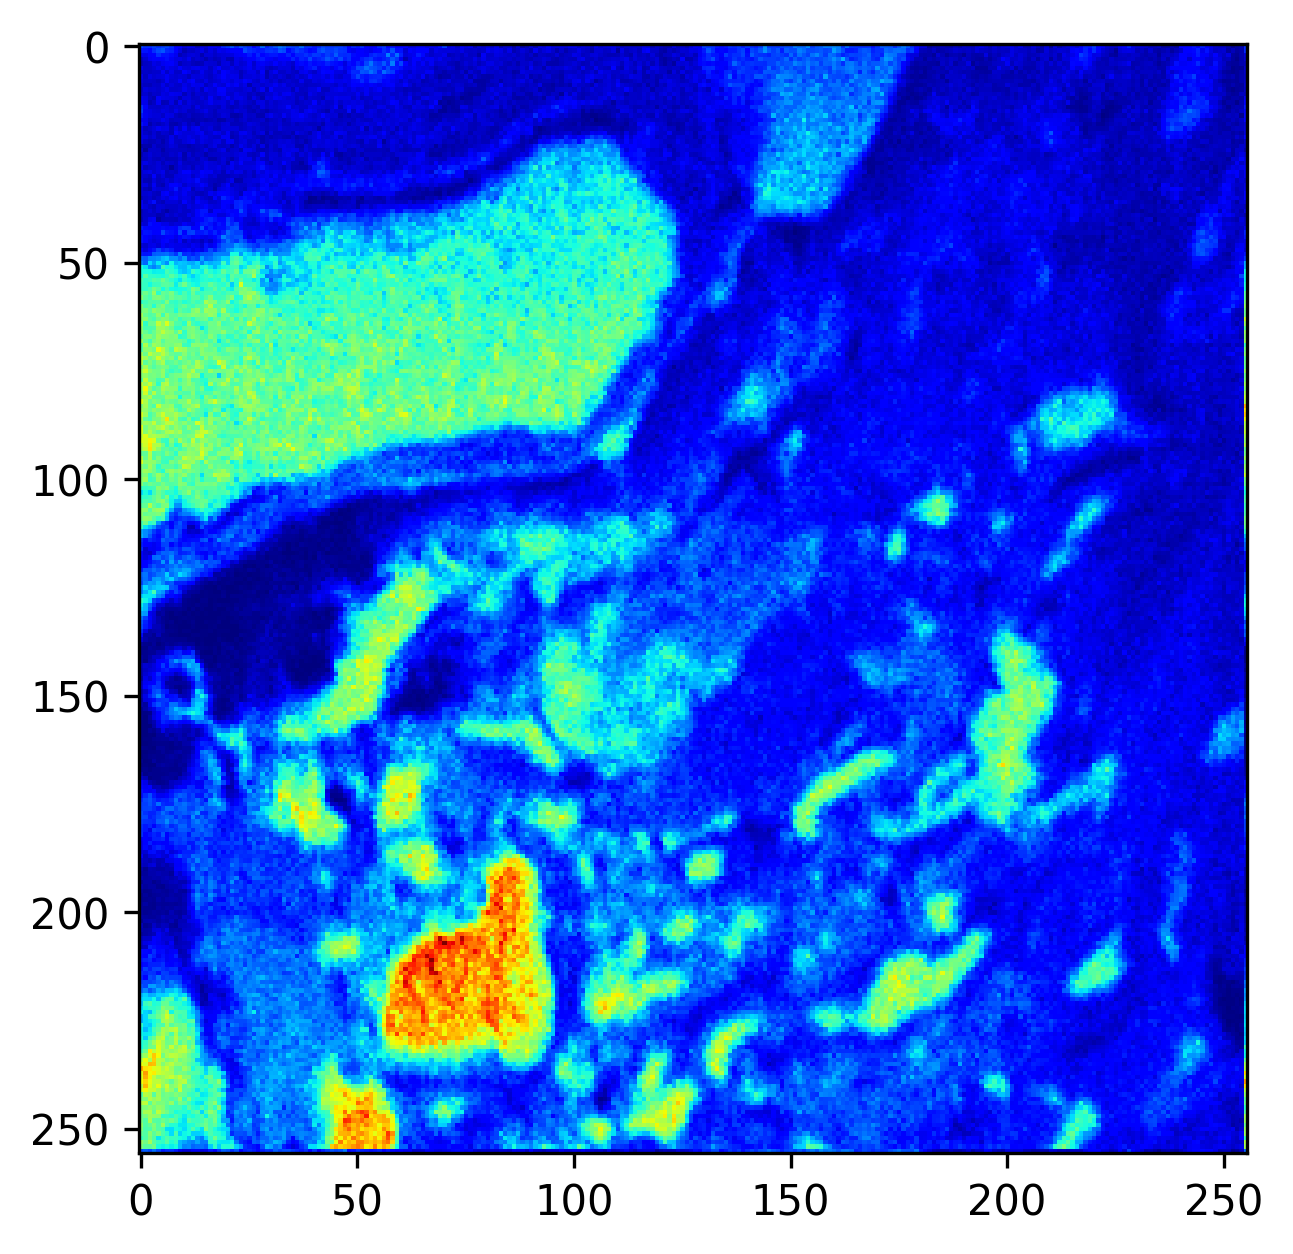

In [13]:
plt.figure(dpi=300)
plt.imshow(data[0,0,:,:])

In [15]:
def roll(data):
    data_rolled = copy.copy(data)
    data_rolled[:, :, :, 0] = np.array(data[:, :, :, -1])
    for col in range(cols-1):
        data_rolled[:, :, :, col+1] = np.array(data[:, :, :, col])

    data_rolled_copy = copy.copy(data_rolled)
    data_rolled[:, :, 0, :] = np.array(data_rolled_copy[:, :, -1, :])  
    for row in range(rows-1):
        data_rolled[:, :, row+1, :] = np.array(data_rolled_copy[:, :, row, :])
   
    return data_rolled

In [16]:
data_roll = roll(data_dtc)

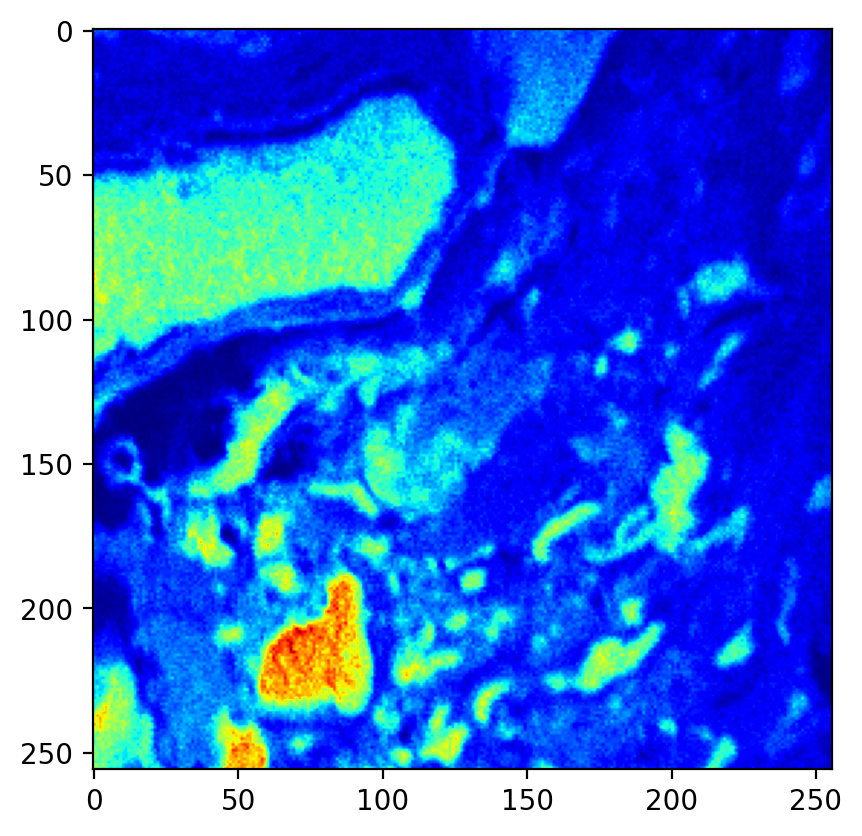

In [17]:
plt.figure(dpi=200)
plt.imshow(data_roll[0,0,:,:])

In [22]:
print("Shape: ", data_roll.shape)
print("Example values: ", data_roll[0,0,0,1], data_roll[0,0,-1,1])

Shape:  (7, 40, 256, 256)
Example values:  65.18643188476562 167.22137451171875


## 3 Align
Align (register) scans by auto-track since NanoSIMS might drift during measurement. The image registration algorithm is based on [P Thevenaz: A Pyramid Approach to Subpixel Registration Based on Intensity](https://infoscience.epfl.ch/record/63055/files/thevenaz9801.pdf).

We select one mass with distinct boundaries as a reference, which is, in our case, the first one, and run the algorithm on all other "higher" than this. 

In [18]:
def align(data, method='autotrack', clipping=False, ref_channel=0, transform='translation'):
    if transform == 'rigid_body':
        sr = StackReg(StackReg.RIGID_BODY)
    if transform == 'translation':
        sr = StackReg(StackReg.TRANSLATION)

    c, _, _, _ = data.shape
    if clipping == True:
        tmats = sr.register_stack((data[ref_channel, :, :, :]-data[ref_channel, :, :, :].min()), axis=0, reference='previous', verbose=False)
        for channel in range(c):
            data[channel, :, :, :] = to_uint16(sr.transform_stack(data[channel, :, :, :]))

    if clipping == False:
        tmats = sr.register_stack(data[ref_channel, :, :, :], axis=0, reference='previous', verbose=False) # axis gives the frame's position
        for channel in range(c):
            data[channel, :, :, :] = sr.transform_stack(data[channel, :, :, :])

    return data

In [19]:
data_align = align(data_roll)

In [21]:
print("Shape: ", data_align.shape)
print("Example values: ", data_align[0,0,0,1], data_align[0,0,-1,1])

Shape:  (7, 40, 256, 256)
Example values:  65.18643188476562 167.22137451171875


## 4 Sum images
Create sum images by adding up all slices.

In [23]:
def sumim(data):
    c, s, w, h = data.shape
    im = np.zeros((c, w, h))
    for i in range(s):
        im += np.asarray(data[:,i,:,:])
    return im

In [24]:
im = sumim(data_align)

In [26]:
print("Shape: ", im.shape)
print("Example values: ", im[0,0,1], im[0,-1,1])

Shape:  (7, 256, 256)
Example values:  2646.0064849853516 5890.978950500488


## 5 Save
Finally, save the image in ".tif" format.

In [27]:
outpath = './ppsim/'
if not os.path.exists(outpath):
    os.mkdir(outpath)

filename = raw.filename.split('/')[-1].split('.')[0]
tifffile.imwrite(f'{outpath}{filename}.tif', im)

# Plot

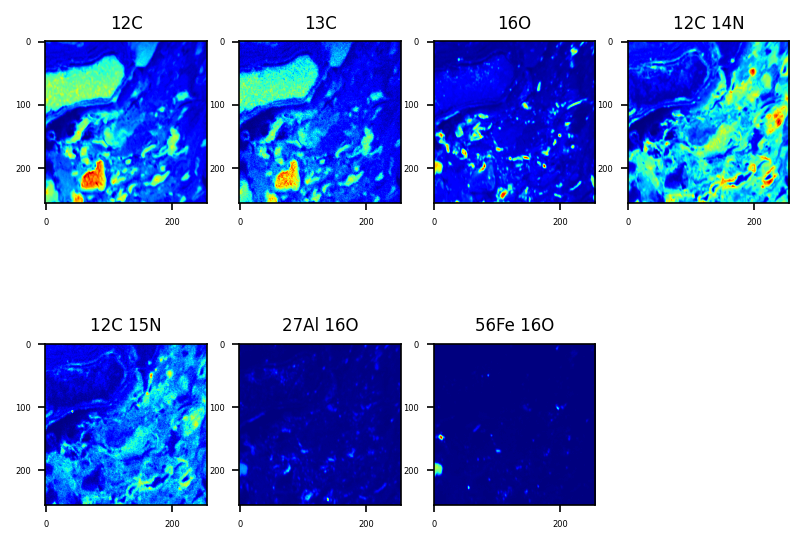

In [31]:
fig = plt.figure(dpi=150)
plt.set_cmap('jet')
plt.tight_layout()
for channel in range(im.shape[0]):
    plt.subplot(2,4,channel+1)
    plt.imshow(im[channel,:,:])
    plt.yticks(fontsize=4)
    plt.xticks(fontsize=4)
    plt.title(species[channel], size=8)
#plt.colorbar(fraction=0.046, pad=0.04)

(array([13075., 21798., 13024.,  6064.,  6560.,  3444.,   597.,   566.,
          358.,    50.]),
 array([   17.09061329,  1212.82730391,  2408.56399454,  3604.30068516,
         4800.03737579,  5995.77406641,  7191.51075704,  8387.24744766,
         9582.98413828, 10778.72082891, 11974.45751953]),
 <BarContainer object of 10 artists>)

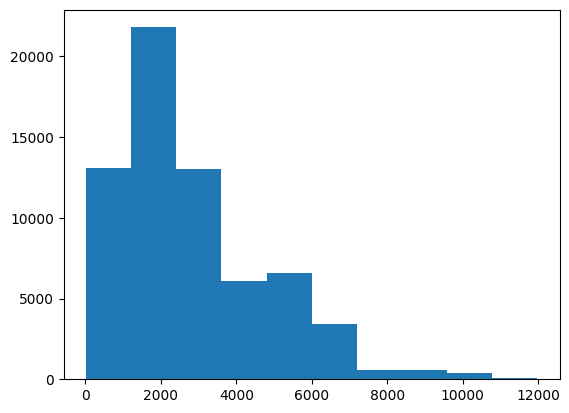

In [37]:
plt.hist(im[0].flatten(), bins=10)